### Date: 17 May 2019

# Using K means clustering to appropriately cluster spectra for each pixel into 5 categories. Each category is then given an empirical $z(\tau)$ relation from simulations. We use these relations to put SIR inversions on a fixed Z scale

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d, UnivariateSpline
import time

In [2]:
def readsim(file):
    raw = np.loadtxt(file)
    return np.transpose(raw.reshape((64,252,252)))

In [3]:
sim_z = np.loadtxt('/Users/neku5162/Desktop/time_series/z_100.csv') *10.0**(5.0) # cgs units [sim_z is a global value of the simulation domain.]
dx = 23.809496*10.0**(5.0)
dy = 23.809496*10.0**(5.0)
dt = 10.0 # 10 second spacing between snapshots I could be wrong here....

mu = 1.2904  # from rh
kb = 1.38064852*10.0**(-16.0) # cgs 
amu = 1.660540*10**(-24.0) # cgs 
g = 27400.0 

In [4]:
sim_tau = np.log10(readsim('/Users/neku5162/Desktop/time_series/tau_100.csv')[:,:,1:])
sim_temp = readsim('/Users/neku5162/Desktop/time_series/t_100.csv')
sim_tau = np.append(np.zeros((252,252,1))-6.0,sim_tau,axis=2) ## append log tau = -6 at the start

In [5]:
raw_spectra = np.transpose(np.loadtxt('spectrum.csv').reshape((257,252,252)))

# Raw un-normalized spectra in CGS units

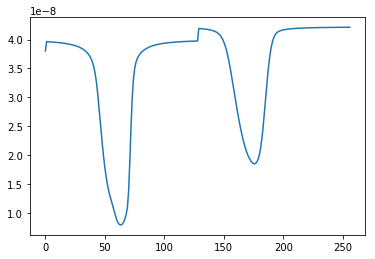

In [6]:
plt.plot(raw_spectra[4,4,:])

# Load in $\tau$ grid used by sir

In [7]:
tau_sir = np.loadtxt('pixels/0_0/guess.mod',skiprows=1)[:,0]

# Interpolate simulation temperature onto SIR tau scale

In [ ]:
sim_temp_tau = np.array([])

for i in np.arange(252):
    for j in np.arange(252):
        temp_tau = interp1d(sim_tau[i,j], sim_temp[i,j],kind='linear',fill_value='extrapolate')
        sim_temp_tau = np.concatenate((sim_temp_tau,temp_tau(tau_sir)))

# sim_temp_tau is an 252x252x64 array. where the 64 dimensions in depth corresponds to the tau grid used in inversions .
# Picking in index along the 3rd dimension gives a plot of the iso-tau temperature surface

In [237]:
# Save as a txt file so I dont have to keep doing these interpolations. Interpolation also removes ringing
np.savetxt('sim_temp_tau.csv',sim_temp_tau.flatten())

In [238]:
sim_temp_tau = np.loadtxt('sim_temp_tau.csv').reshape((252,252,len(tau_sir)))

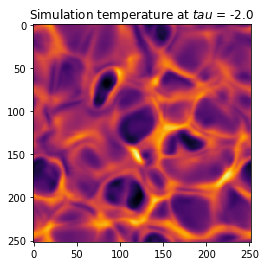

In [246]:
index = 40
plt.imshow(sim_temp_tau[:,:,index],cmap='inferno')
plt.title('Simulation temperature at $tau$ = ' + str(round(tau_sir[index],2)))
plt.show()

## Import temperature data from inversions and compare to simulations on $\tau$ scale

In [113]:
temp_inversions = np.loadtxt('myfile.dat')
t_sir = np.transpose(temp_inversions.reshape(252,252,64),axes=[1,0,2])

In [249]:
def temp_tau_compare(index):
    
    sim = sim_temp_tau[:,:,index]
    plt.imshow(gaussian_filter(sim,1),cmap='inferno')
    plt.colorbar() 
    plt.title(' Simulation log tau = '+ str(round(tau_sir[index],2)))
    tup = np.max(sim)
    tlo = np.min(sim)

    plt.clim(tup,tlo)
    plt.show()
    
    sir_temp = (t_sir[:,:,index])
    plt.imshow(gaussian_filter(sir_temp,1),cmap='inferno')
    plt.title(' SIR log tau = '+ str(round(tau_sir[index],2)))
    tup = np.max(t_sir[:,:,index])
    tlo = np.min(t_sir[:,:,index])
    plt.colorbar()
    plt.clim(tup,tlo)
    plt.show()

    # This function allows us to compare the temperatures on the tau scale in the simulation and inversion.
    # Hence, this is just a test of how well the SIR code is doing. 
    # I apply a smalll gaussian filter to remove some small scale hot pixels in the inversions


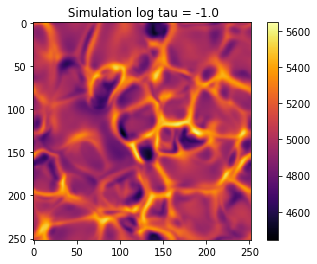

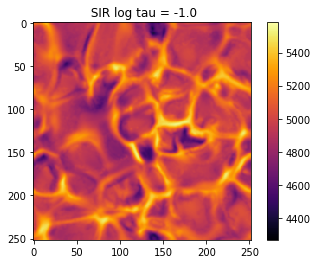

In [367]:
temp_tau_compare(30)

In [250]:
def rms_diff(index):
    sir_temp = t_sir[:,:,index]
    sim = sim_temp_tau[:,:,index]
    
    diff_sq = np.ndarray.flatten( ((sir_temp - sim)/sim)**2.0 )
    return np.sqrt(np.mean(diff_sq))

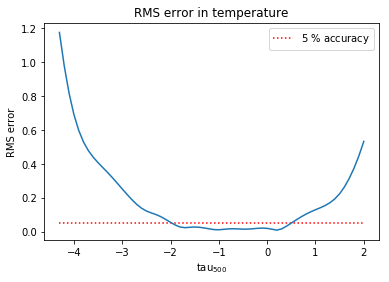

In [251]:
plt.plot(tau_sir,[rms_diff(i) for i in np.arange(len(tau_sir))])
plt.hlines(0.05,np.min(tau_sir),np.max(tau_sir), label = '5 $\%$ accuracy', linestyles=':',color='red')
plt.title('RMS error in temperature')
plt.xlabel('tau$_{500}$')
plt.ylabel('RMS error')
plt.legend()
plt.show()

## The inversion recovers the temperature stratification in the $\tau$ scale well between  -2 < log tau < 0.

# K means clustering to classify pixels based on spectra

In [121]:
from sklearn.cluster import KMeans

In [130]:
kmeans_raw = KMeans(n_clusters=5,init = 'k-means++' , random_state=5).fit(raw_spectra.reshape((252*252,257)))


# K means algorithm is relatively robust for normalized vs un -normalized spectra and different initial seeds.

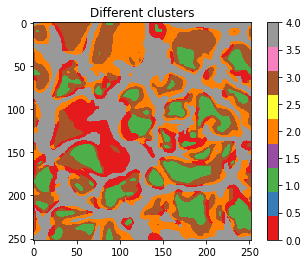

In [252]:
plt.imshow(kmeans_raw.labels_.reshape((252,252)),cmap='Set1')
plt.colorbar()
plt.title('Different clusters')
plt.show()

# Cluster centers are essentially based on intensity

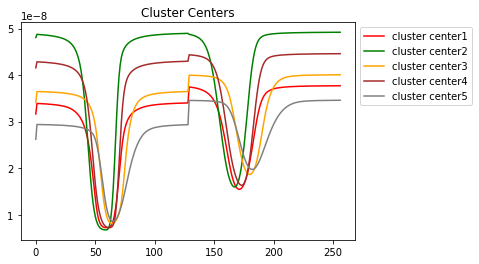

In [261]:
colors = ['red','green', 'orange', 'brown','grey']
for i in np.arange(5):
    plt.plot(kmeans_raw.cluster_centers_[i],label = 'cluster center' + str(i+1),color = colors[i])
    plt.legend()
plt.title('Cluster Centers')
plt.legend(bbox_to_anchor=(1, 0, 0, 1))

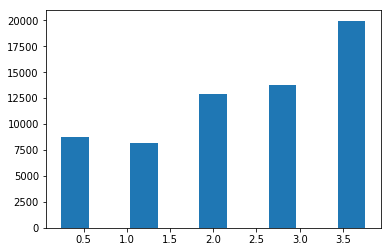

In [262]:
cluster_labels = kmeans_raw.labels_.reshape((252,252))
plt.hist(cluster_labels.flatten(),bins=5,align='mid',rwidth=0.4)
plt.show()

## Note we're doing our clustering based on the spectra, not on the continuum intensity. The hope is that the clustering on spectra also produces a similar 'clustering' in the z(tau) profiles

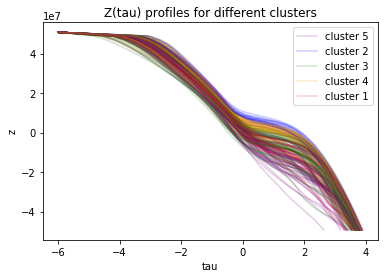

In [368]:
from collections import OrderedDict

for index in np.arange(200):
    
    i = np.random.randint(252)
    j = np.random.randint(252)
    
    if cluster_labels[i,j] == 0:
        plt.plot(sim_tau[i,j,:],sim_z[:],color = 'red',alpha = 0.2,   label = 'cluster 1')
    if cluster_labels[i,j] == 1:
        plt.plot(sim_tau[i,j,:],sim_z[:],color = 'blue',alpha = 0.2,  label = 'cluster 2')
    if cluster_labels[i,j] == 2:
        plt.plot(sim_tau[i,j,:],sim_z[:],color = 'green',alpha = 0.2, label = 'cluster 3')
    if cluster_labels[i,j] == 3:
        plt.plot(sim_tau[i,j,:],sim_z[:],color = 'orange',alpha = 0.2,label = 'cluster 4')
    if cluster_labels[i,j] == 4:
        plt.plot(sim_tau[i,j,:],sim_z[:],color = 'purple',alpha = 0.2,label = 'cluster 5')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.ylabel('z')
plt.xlabel('tau')
plt.title('Z(tau) profiles for different clusters')
plt.show()

# Now we construct an average tau vs z for each of the clusters:

In [161]:
tau_cluster_1 = np.zeros(64)
tau_cluster_2 = np.zeros(64)
tau_cluster_3 = np.zeros(64)
tau_cluster_4 = np.zeros(64)
tau_cluster_5 = np.zeros(64)


num1 = np.count_nonzero(cluster_labels.flatten() == 0)
num2 = np.count_nonzero(cluster_labels.flatten() == 1)
num3 = np.count_nonzero(cluster_labels.flatten() == 2)
num4 = np.count_nonzero(cluster_labels.flatten() == 3)
num5 = np.count_nonzero(cluster_labels.flatten() == 4)


for i in np.arange(252):
    for j in np.arange(252):

        if cluster_labels[i,j] == 0:
            tau_cluster_1 += sim_tau[i,j,:]

        if cluster_labels[i,j] == 1:
            tau_cluster_2 += sim_tau[i,j,:]
            
        if cluster_labels[i,j] == 2:
            tau_cluster_3 += sim_tau[i,j,:]
            
        if cluster_labels[i,j] == 3:
            tau_cluster_4 += sim_tau[i,j,:]

        if cluster_labels[i,j] == 4:
            tau_cluster_5 += sim_tau[i,j,:]

    
tau_cluster_1= tau_cluster_1/num1
tau_cluster_2= tau_cluster_2/num2
tau_cluster_3= tau_cluster_3/num3
tau_cluster_4= tau_cluster_4/num4
tau_cluster_5= tau_cluster_5/num5


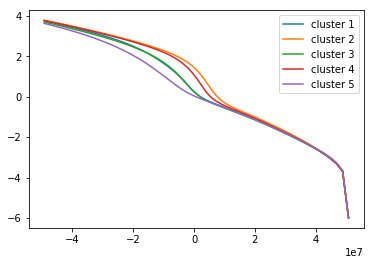

In [163]:
plt.plot(sim_z,tau_cluster_1,label = 'cluster 1')
plt.plot(sim_z,tau_cluster_2,label = 'cluster 2')
plt.plot(sim_z,tau_cluster_3,label = 'cluster 3')
plt.plot(sim_z,tau_cluster_4,label = 'cluster 4')
plt.plot(sim_z,tau_cluster_5,label = 'cluster 5')
plt.legend()

# The resulting tau vs z profiles are quite different. This leads me to think that the clustering algorithm is actually doing something useful... However, cluster's 1 and 3 have very similar z vs tau profiles

# Convert these into interpolating functions:

In [269]:
# gives z as a function of tuau for SIR in each cluster
z_c1 = interp1d(tau_cluster_1, (1e-5)*sim_z[:],kind='linear')
z_c2 = interp1d(tau_cluster_2, (1e-5)*sim_z[:],kind='linear')
z_c3 = interp1d(tau_cluster_3, (1e-5)*sim_z[:],kind='linear')
z_c4 = interp1d(tau_cluster_4, (1e-5)*sim_z[:],kind='linear')
z_c5 = interp1d(tau_cluster_5, (1e-5)*sim_z[:],kind='linear')

# gives tau as a function of z for SIR in each cluster

tau_c1 = interp1d((1e-5)*sim_z[:],tau_cluster_1,kind='linear',fill_value='extrapolate')
tau_c2 = interp1d((1e-5)*sim_z[:],tau_cluster_2,kind='linear',fill_value='extrapolate')
tau_c3 = interp1d((1e-5)*sim_z[:],tau_cluster_3,kind='linear',fill_value='extrapolate')
tau_c4 = interp1d((1e-5)*sim_z[:],tau_cluster_4,kind='linear',fill_value='extrapolate')
tau_c5 = interp1d((1e-5)*sim_z[:],tau_cluster_5,kind='linear',fill_value='extrapolate')


In [270]:
cluster_z_cube = np.zeros((252,252,64))  # cluster_z_cube is an array of the interpolated z positions down each pixel

for i in np.arange(252):
    for j in np.arange(252):
        
        if cluster_labels[i,j] == 0:
            cluster_z_cube[i,j] = z_c1(tau_sir)

        if cluster_labels[i,j] == 1:
            cluster_z_cube[i,j] = z_c2(tau_sir)
            
        if cluster_labels[i,j] == 2:
            cluster_z_cube[i,j] = z_c3(tau_sir)
            
        if cluster_labels[i,j] == 3:
            cluster_z_cube[i,j] = z_c4(tau_sir)

        if cluster_labels[i,j] == 4:
            cluster_z_cube[i,j] = z_c5(tau_sir)



# Let's see how well the clustering/interpolation did? (For a given pixel)

185 112


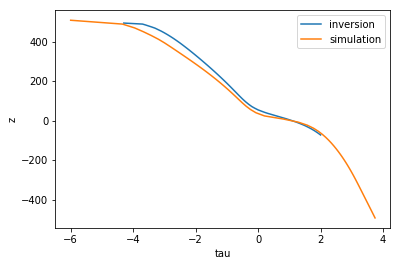

In [380]:
i = np.random.randint(252)
j = np.random.randint(252)

plt.plot(tau_sir,cluster_z_cube[i,j,:],label = 'inversion')
plt.ylabel('z')
plt.xlabel('tau')

plt.plot(sim_tau[i,j,:],sim_z[:]*(1e-5),label = 'simulation')
plt.legend()
print(i,j)

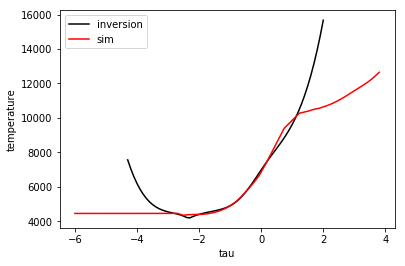

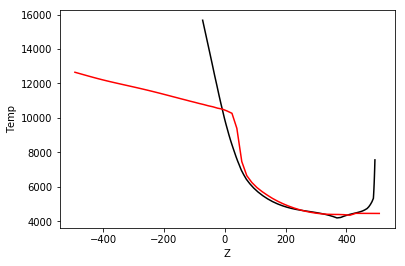

In [385]:
i = np.random.randint(252)
j = np.random.randint(252)

plt.plot(tau_sir,t_sir[i,j,:],label='inversion', color='black')
plt.plot(sim_tau[i,j],sim_temp[i,j,:],label = 'sim', color = 'red')
plt.xlabel('tau')
plt.ylabel('temperature')
plt.legend()
plt.show()

plt.plot(cluster_z_cube[i,j,:],t_sir[i,j,:],'black')
plt.plot(sim_z*(1e-5),sim_temp[i,j,:],'red')
plt.ylabel('Temp')
plt.xlabel('Z')
plt.show()

# Now we reconstruct an image slice:

In [226]:
def cluster_reconstruct(k_index):
    tau_avg = np.mean(sim_tau[:,:,k_index]) # average value of log tau at this height
    z_val = sim_z[k_index] # True z value for this index
    true_temp = sim_temp[:,:,k_index] # temperature at this height in simulation
    
    plt.imshow(gaussian_filter(true_temp,1),cmap='inferno')
    
    tup = np.max(true_temp)
    tlo = np.min(true_temp)
    
    plt.colorbar()
    plt.clim(tlo,tup)
    plt.title('Temp at z = '+str(round(z_val*(1e-5),2))+'km ($tau \sim$' + str(round(tau_avg,2))+ ')')
    plt.savefig('t_original.png')
    plt.show()
    
    
    ### Now do SIR
    
    tau_c1_val = tau_c1(z_val*(1e-5))
    tau_c2_val = tau_c2(z_val*(1e-5))
    tau_c3_val = tau_c3(z_val*(1e-5))
    tau_c4_val = tau_c4(z_val*(1e-5))
    tau_c5_val = tau_c5(z_val*(1e-5))

    sir_reconstruct_temp = np.zeros((252,252))  # reconstruct temperatures based on inferred positions

    for i in np.arange(252):
        for j in np.arange(252):
            
            sir_temp_tau = interp1d(tau_sir,t_sir[i,j,:],fill_value='extrapolate')  # interpolate temperature values on tau grid 
            
            if cluster_labels[i,j] == 0:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c1_val)
            if cluster_labels[i,j] == 1:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c2_val)
            if cluster_labels[i,j] == 2:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c3_val)
            if cluster_labels[i,j] == 3:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c4_val)
            if cluster_labels[i,j] == 4:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c5_val)
                
            
    
    plt.imshow(gaussian_filter(sir_reconstruct_temp,1),cmap='inferno')
    plt.colorbar()
    plt.clim(tlo,tup)
    plt.title('Reconstructed temp at z = '+str(round(z_val*(1e-5),2))+'km ($tau \sim$' + str(round(tau_avg,2))+ ')')
    plt.savefig('t_recons.png')
    plt.show()

        


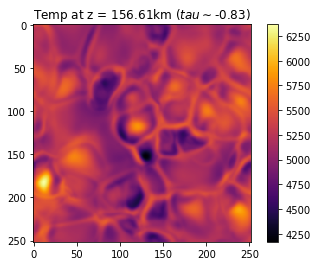

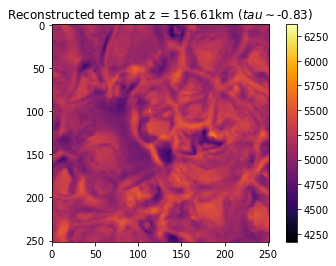

In [390]:
cluster_reconstruct(19)

### Reconstructions look pretty good even on the Z scale. 

In [299]:
def rms_temp_diff_z(k_index):
    z_val = sim_z[k_index]
    true_temp = gaussian_filter(sim_temp[:,:,k_index],1) # temperature at this height in simulation
    
    ### Now do SIR
    
    tau_c1_val = tau_c1(z_val*(1e-5))
    tau_c2_val = tau_c2(z_val*(1e-5))
    tau_c3_val = tau_c3(z_val*(1e-5))
    tau_c4_val = tau_c4(z_val*(1e-5))
    tau_c5_val = tau_c5(z_val*(1e-5))

    sir_reconstruct_temp = np.zeros((252,252))  # reconstruct temperatures based on inferred positions

    for i in np.arange(252):
        for j in np.arange(252):
            
            sir_temp_tau = interp1d(tau_sir,t_sir[i,j,:],fill_value='extrapolate')  # interpolate temperature values on tau grid 
            
            if cluster_labels[i,j] == 0:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c1_val)
            if cluster_labels[i,j] == 1:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c2_val)
            if cluster_labels[i,j] == 2:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c3_val)
            if cluster_labels[i,j] == 3:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c4_val)
            if cluster_labels[i,j] == 4:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c5_val)

    reconstructed = gaussian_filter(sir_reconstruct_temp,1)
    
    return np.sqrt(np.mean( ( ( (reconstructed-true_temp)/true_temp)**2).flatten()))



In [350]:
def scatter_plot_diff(k_index):
   
    tau_avg = np.mean(sim_tau[:,:,k_index]) # average value of log tau at this height
    z_val = sim_z[k_index] # True z value for this index
    true_temp = sim_temp[:,:,k_index] # temperature at this height in simulation
        
    tup = np.max(true_temp)
    tlo = np.min(true_temp)
    
    
    
    z_val = sim_z[k_index]
    true_temp = gaussian_filter(sim_temp[:,:,k_index],1) # temperature at this height in simulation
    
    ### Now do SIR
    
    tau_c1_val = tau_c1(z_val*(1e-5))
    tau_c2_val = tau_c2(z_val*(1e-5))
    tau_c3_val = tau_c3(z_val*(1e-5))
    tau_c4_val = tau_c4(z_val*(1e-5))
    tau_c5_val = tau_c5(z_val*(1e-5))

    sir_reconstruct_temp = np.zeros((252,252))  # reconstruct temperatures based on inferred positions

    for i in np.arange(252):
        for j in np.arange(252):
            
            sir_temp_tau = interp1d(tau_sir,t_sir[i,j,:],fill_value='extrapolate')  # interpolate temperature values on tau grid 
            
            if cluster_labels[i,j] == 0:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c1_val)
            if cluster_labels[i,j] == 1:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c2_val)
            if cluster_labels[i,j] == 2:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c3_val)
            if cluster_labels[i,j] == 3:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c4_val)
            if cluster_labels[i,j] == 4:
                sir_reconstruct_temp[i,j] = sir_temp_tau(tau_c5_val)

    reconstructed = gaussian_filter(sir_reconstruct_temp,1)
    
    plt.title('Temp at z = '+str(round(z_val*(1e-5),2))+'km ($tau \sim$' + str(round(tau_avg,2))+ ')')
    plt.scatter(true_temp.flatten(),reconstructed.flatten(),alpha=0.2,s = 1.0)
    plt.xlabel('true Temperature')
    plt.ylabel('Reconstructed temperature')
    plt.plot(true_temp.flatten(),true_temp.flatten(),alpha=0.2,color = 'red')

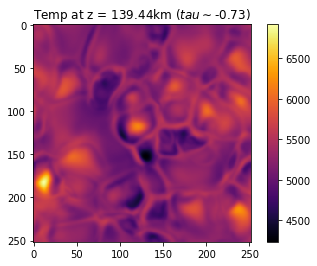

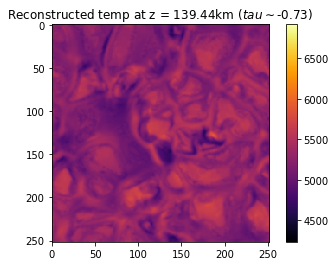

In [293]:
cluster_reconstruct(20)

In [300]:
temp_z_diff_list = [rms_temp_diff_z(i) for i in np.arange(64)]

Text(0, 0.5, 'RMS error')

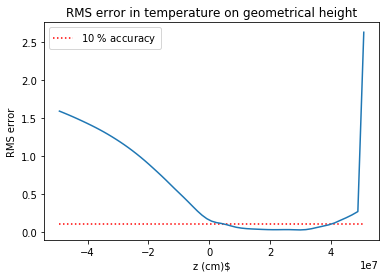

In [310]:
plt.plot(sim_z,temp_z_diff_list)
plt.hlines(0.1,np.min(sim_z),np.max(sim_z), label = '10 $\%$ accuracy', linestyles=':',color='red')
plt.legend()
plt.title('RMS error in temperature on geometrical height')
plt.xlabel('z (cm)$')
plt.ylabel('RMS error')


### Hence, the root mean square temperature deviation is around ~ 10 perecent

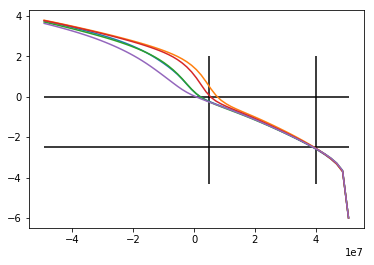

In [323]:
plt.plot(sim_z,tau_c1(sim_z*(1e-5)))
plt.plot(sim_z,tau_c2(sim_z*(1e-5)))
plt.plot(sim_z,tau_c3(sim_z*(1e-5)))
plt.plot(sim_z,tau_c4(sim_z*(1e-5)))
plt.plot(sim_z,tau_c5(sim_z*(1e-5)))
plt.vlines(0.5e7,np.min(tau_sir),np.max(tau_sir))
plt.vlines(4e7,np.min(tau_sir),np.max(tau_sir))
plt.hlines(0,np.min(sim_z),np.max(sim_z))
plt.hlines(-2.5,np.min(sim_z),np.max(sim_z))


### For most of the domain, we senstive to, the different clustering curves look fairly identical. It's only near the tau ~0 region where theybecome diffrent. They are are also different slightly deeper in but the spectra is not sensitive to the atmosphere if you go too deep.

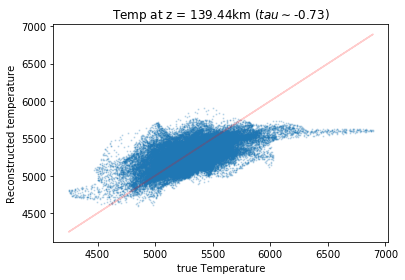

In [404]:
scatter_plot_diff(20)

### Looking at the scatterplot of the difference in RMS temperature at a given height, we can see that, the true temperature is a little higher than the reconstructed temperature.... There area a few hot pixels which we're not able to reconstruct. For the vast majority of pixels though, acceptable

# Next steps:

## What we're really interested in the anisotropy in the radiation field. This is parametrized by $J_0$

### TODO:

### Try and look At pressure between neighbroing pixels to determine pixel shifts.
### Note that we're still assuming hydrostatic equilibrium in our inversions.
### Inspite of that, it looks pretty good.


In [357]:
ne = readsim('/Users/neku5162/Desktop/time_series/nelec_100.csv')
nh = readsim('/Users/neku5162/Desktop/time_series/nh_100.csv')

rho = mu*nh*amu
pe = ne * kb * sim_temp   # electron pressures
p = rho * kb * sim_temp / (mu*amu)

p_tot = p + pe

Text(0, 0.5, 'Gas pressure')

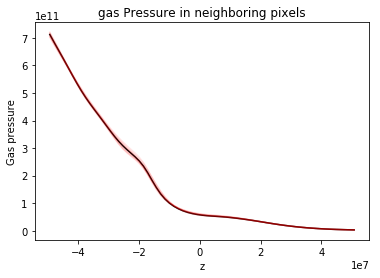

In [401]:
i,j = [np.random.randint(252),np.random.randint(252)]

plt.plot(sim_z,p_tot[i,j,:],label = 'pixel' , color = 'black')

plt.plot(sim_z,p_tot[i,j+1,:],label = 'pixel' , color = 'red',alpha = 0.1)
plt.plot(sim_z,p_tot[i+1,j,:],label = 'pixel' , color = 'red',alpha = 0.1)
plt.plot(sim_z,p_tot[i-1,j,:],label = 'pixel' , color = 'red',alpha = 0.1)
plt.plot(sim_z,p_tot[i,j-1,:],label = 'pixel' , color = 'red',alpha = 0.1)

plt.plot(sim_z,p_tot[i+1,j+1,:],label = 'pixel' , color = 'red',alpha = 0.1)
plt.plot(sim_z,p_tot[i+1,j-1,:],label = 'pixel' , color = 'red',alpha = 0.1)
plt.plot(sim_z,p_tot[i-1,j+1,:],label = 'pixel' , color = 'red',alpha = 0.1)
plt.plot(sim_z,p_tot[i-1,j-1,:],label = 'pixel' , color = 'red',alpha = 0.1)
plt.title('gas Pressure in neighboring pixels')
plt.xlabel('z')
plt.ylabel('Gas pressure')


Text(0, 0.5, 'electron pressure')

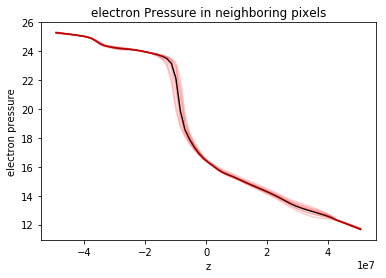

In [363]:
i,j = [np.random.randint(252),np.random.randint(252)]


plt.plot(sim_z,np.log(pe)[i,j,:],label = 'pixel' , color = 'black')

plt.plot(sim_z,np.log(pe)[i,j+1,:],label = 'pixel' , color = 'red',alpha = 0.2)
plt.plot(sim_z,np.log(pe)[i+1,j,:],label = 'pixel' , color = 'red',alpha = 0.2)
plt.plot(sim_z,np.log(pe)[i-1,j,:],label = 'pixel' , color = 'red',alpha = 0.2)
plt.plot(sim_z,np.log(pe)[i,j-1,:],label = 'pixel' , color = 'red',alpha = 0.2)

plt.plot(sim_z,np.log(pe)[i+1,j+1,:],label = 'pixel' , color = 'red',alpha = 0.2)
plt.plot(sim_z,np.log(pe)[i+1,j-1,:],label = 'pixel' , color = 'red',alpha = 0.2)
plt.plot(sim_z,np.log(pe)[i-1,j+1,:],label = 'pixel' , color = 'red',alpha = 0.2)
plt.plot(sim_z,np.log(pe)[i-1,j-1,:],label = 'pixel' , color = 'red',alpha = 0.2)
plt.title('electron Pressure in neighboring pixels')
plt.xlabel('z')
plt.ylabel('electron pressure')


### The point is that electron pressure determines the spectra, other quantities like gas pressure and density are calcuated after assuming hydrostatic equilibrium. 

### We could match electron pressure between neighboring pixels to determine pixel offsrts/ 